# FORECASTING DE VENTAS MOTOS

In [1]:
%pip install pandas seaborn matplotlib pmdarima statsmodels scikit-learn skforecast tensorflow keras


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show tensorflow


Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\edwin luna\appdata\roaming\python\python39\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# IMPORTANDO LIBRERIAS

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
import re
import warnings
import matplotlib.dates as mdates
import numpy as np
from io import StringIO
import contextlib
from sklearn import metrics
import plotly.express as px
from sklearn.model_selection import ParameterGrid

#LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras import regularizers
from keras.layers import Dropout
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# IMPORTAMOS LOS DATOS

In [4]:
# Ignora el aviso al leer el archivo
datos = pd.read_csv('ventas_africa_twin_2003_2023.csv', low_memory=False)

In [5]:
datos.head()

ref_fecha  ref_doc_venta_neta
0  2003-01-31         77536.00000
1  2003-02-28         78046.00000
2  2003-03-31         82972.44361
3  2003-04-30        100106.54745
4  2003-05-31         77848.40057

In [6]:
datos['ref_fecha'] = pd.to_datetime(datos['ref_fecha'], format='%Y-%m-%d')
datos = datos.set_index('ref_fecha')
datos = datos.asfreq('ME')
display(datos.head(4))

ref_doc_venta_neta
ref_fecha                     
2003-01-31         77536.00000
2003-02-28         78046.00000
2003-03-31         82972.44361
2003-04-30        100106.54745

In [7]:
ventas_mensuales = datos.copy()

FUNCION PARA EVALUAR

In [8]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [9]:
# Verificar valores nulos en la serie
print("Valores nulos en la serie original:")
print(datos.isnull().sum())

# Verificar si hay infinitos
print("\nValores infinitos en la serie original:")
print(np.isinf(datos).sum())


Valores nulos en la serie original:
ref_doc_venta_neta    0
dtype: int64

Valores infinitos en la serie original:
ref_doc_venta_neta    0
dtype: int64


In [10]:
import pandas as pd
import numpy as np

# Supongamos que 'datos' es tu DataFrame original
# Verificar valores nulos en la serie
print("Valores nulos en la serie original:")
print(datos.isnull().sum())

# Muestra las filas con valores nulos en ref_doc_venta_neta
nulos = datos[datos['ref_doc_venta_neta'].isnull()]
print("\nFilas con valores nulos en 'ref_doc_venta_neta':")
print(nulos)

# Verificar si hay infinitos
print("\nValores infinitos en la serie original:")
print(np.isinf(datos).sum())

# Muestra las filas con valores infinitos en ref_doc_venta_neta
infinitos = datos[np.isinf(datos['ref_doc_venta_neta'])]
print("\nFilas con valores infinitos en 'ref_doc_venta_neta':")
print(infinitos)



Valores nulos en la serie original:
ref_doc_venta_neta    0
dtype: int64

Filas con valores nulos en 'ref_doc_venta_neta':
Empty DataFrame
Columns: [ref_doc_venta_neta]
Index: []

Valores infinitos en la serie original:
ref_doc_venta_neta    0
dtype: int64

Filas con valores infinitos en 'ref_doc_venta_neta':
Empty DataFrame
Columns: [ref_doc_venta_neta]
Index: []


# ESTACIONARIEDAD

In [11]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = datos.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
datos.plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2')

Test estacionariedad serie original
-------------------------------------
ADF Statistic: 0.1923696036669279, p-value: 0.971830366333906
KPSS Statistic: 2.3757789652018584, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -5.73199753451186, p-value: 6.567628515305539e-07
KPSS Statistic: 0.007137177444967024, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -12.05135343476986, p-value: 2.5929693416319403e-22
KPSS Statistic: 0.029450753763808027, p-value: 0.1


<Axes: title={'center': 'Diferenciación orden 2'}, xlabel='ref_fecha'>


 ADF
 Hipótesis nula ( HO ): La serie tiene una raíz unitaria, no es estacionaria.
 Hipótesis alternativa ( HA ): La serie no tiene raíz unitaria, es estacionaria.

KPSS
 Hipótesis nula ( HO ): La serie es estacionaria.
 Hipótesis alternativa ( HA ): La serie no es estacionaria.

 En base a las Pruebas de Dickey-Fuller aumentada y Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
 se comprueba que la serie original no es estacionaria


# ANÁLISIS DE AUTOCORRELACIÓN

In [12]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)')

Text(0.5, 1.0, 'Autocorrelación serie diferenciada (order=1)')


 La ACF presenta un patron sinusoidal por lo que se sugiere la presencia de estacionalidad (12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


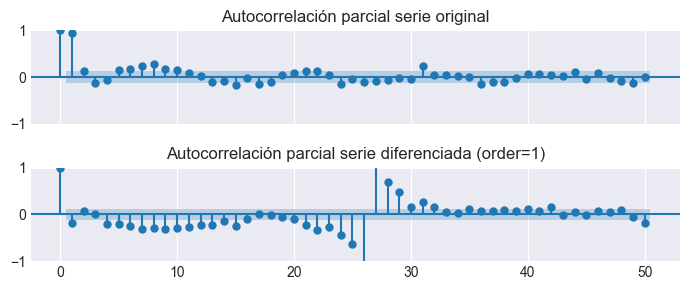

In [13]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación parcial serie diferenciada (order=1)');
plt.tight_layout()

## DESCOMPOSICIÓN DE SERIES TEMPORALES

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie original y la serie diferenciada
# ==============================================================================

# Asegúrate de definir correctamente el periodo de la estacionalidad (ejemplo: 12 si es anual)
periodo = 12  # Cambia esto si la frecuencia de tus datos es diferente

# Descomponer la serie original
res_decompose = seasonal_decompose(datos, model='additive', period=periodo, extrapolate_trend='freq')

# Descomponer la serie diferenciada
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', period=periodo, extrapolate_trend='freq')

# Crear subplots para visualizar las descomposiciones
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

# Serie original
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos')

# Serie diferenciada (order=1)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos')

# Título general y ajuste del diseño
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout()
plt.show()


El patron recurrente cada 12 meses sugiere una estacionalidad anual confirmando lo observado en el gráfico ACF ya que se observan picos significativos en los lags correspondientes a los intervalos de 12 meses, confirmando la idea de
patrones recurrentes


In [15]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = datos.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -7.081785658977973, p-value: 4.646153778922972e-10
KPSS Statistic: 0.04689622947586108, p-value: 0.1


1. Prueba ADF (Augmented Dickey-Fuller):
Hipótesis nula (H0): La serie tiene una raíz unitaria, es decir, no es estacionaria.
Hipótesis alternativa (H1): La serie es estacionaria.
Interpretación:
ADF Statistic: -6.35
p-value: 2.61e-08 (muy bajo)
Dado que el valor p es mucho menor que el nivel de significancia comúnmente usado (como 0.05), rechazas la hipótesis nula. Esto significa que, según la prueba ADF, la serie diferenciada (combinación de diferenciación de orden 1 y diferenciación estacional) es estacionaria.

2. Prueba KPSS (Kwiatkowski-Phillips-Schmidt-Shin):
Hipótesis nula (H0): La serie es estacionaria.
Hipótesis alternativa (H1): La serie tiene una tendencia o no es estacionaria.
Interpretación:
KPSS Statistic: 0.030
p-value: 0.1
Aquí el valor p es mayor que 0.05, por lo que no rechazas la hipótesis nula.

Según la prueba KPSS, la serie es estacionaria.Con base en los resultados del análisis exploratorio, emplear una combinación de diferenciación de primer orden y diferenciación estacional podría ser el método más adecuado. La diferenciación de primer orden es útil para captar las transiciones entre observaciones y destacar las fluctuaciones a corto plazo. A su vez, la diferenciación estacional, que abarca un período de 12 meses y refleja el cambio anual, permite capturar los patrones cíclicos presentes en los datos. Esta estrategia facilita alcanzar la estacionariedad requerida para el posterior modelado ARIMA.

# SEPARAMOS LOS DATOS EN TRAIN Y TEST

In [16]:
# Calcular la fecha de corte para dividir entre entrenamiento y prueba (80-20 split)
fin_train = datos.index[int(len(datos) * 0.7)]

# Dividir los datos en conjunto de entrenamiento y prueba
datos_train = datos.loc[datos.index <= fin_train]
datos_test = datos.loc[datos.index > fin_train]
test=datos_test.copy()
train=datos_train.copy()

# Imprimir la longitud de los conjuntos de entrenamiento y prueba
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.set_title('Ventas Netas Mensuales Cluster Bebidas')
ax.legend()
plt.show()


Fechas train : 2003-01-31 00:00:00 --- 2017-09-30 00:00:00  (n=177)
Fechas test  : 2017-10-31 00:00:00 --- 2023-12-31 00:00:00  (n=75)


# MODELO ARIMA-SARIMAX

## STATSMODELS

In [17]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 ref_doc_venta_neta   No. Observations:                  177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1852.256
Date:                            Wed, 02 Oct 2024   AIC                           3714.513
Time:                                    22:36:22   BIC                           3730.012
Sample:                                01-31-2003   HQIC                          3720.805
                                     - 09-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0294      0.210      0.140      0.889      -0.383       0.442
ma.L1         -0.7140      0.143     -4.983      0.000      -0.995      -0.433
ar.S.L12      -0.1427      0.168     -0.848      0.397      -0.473       0.187
ma.S.L12      -0.6779      0.168     -4.047      0.000      -1.006      -0.350
sigma2       5.63e+08   8.11e-11   6.94e+18      0.000    5.63e+08    5.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.41   Prob(JB):                         0.56
Heteroskedasticity (H):               0.84   Skew:                            -0.12
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.34e+35. Standard errors may be unstable.
"""

In [18]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels)

2017-10-31    264540.158035
2017-11-30    243267.026931
2017-12-31    228934.502100
2018-01-31    223331.482625
2018-02-28    228850.007480
                  ...      
2023-08-31    355943.146344
2023-09-30    350008.411949
2023-10-31    343261.473920
2023-11-30    322784.235093
2023-12-31    309623.973441
Freq: ME, Name: predicciones_statsmodels, Length: 75, dtype: float64

In [19]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones_statsmodels)

Evaluation metric results:-
MSE is : 852625555.654658
MAE is : 20847.851944366477
RMSE is : 29199.752664271968
MAPE is : 9.054057437170203
R2 is : 0.566871934188152



## Modelo SARIMAX con skforecast.Sarimax 

In [20]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()
warnings.filterwarnings("default")

In [21]:
# Predictión
# ==============================================================================
predicciones_skforecast = modelo.predict(steps=len(datos_test))
display(predicciones_skforecast.head(4))

pred
2017-10-31  264540.158035
2017-11-30  243267.026931
2017-12-31  228934.502100
2018-01-31  223331.482625

In [22]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones_skforecast)

Evaluation metric results:-
MSE is : 852625555.654658
MAE is : 20847.851944366477
RMSE is : 29199.752664271968
MAPE is : 18.71848195497547
R2 is : 0.566871934188152



## PDMARIMA

In [23]:
# Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
modelo = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1853.708
Date:                            Wed, 02 Oct 2024   AIC                           3719.416
Time:                                    22:36:23   BIC                           3738.015
Sample:                                01-31-2003   HQIC                          3726.966
                                     - 09-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    335.9617    508.910      0.660      0.509    -661.483    1333.406
ar.L1         -0.0983      0.221     -0.444      0.657      -0.532       0.335
ma.L1         -0.5859      0.183     -3.201      0.001      -0.945      -0.227
ar.S.L12      -0.1552      0.173     -0.898      0.369      -0.494       0.184
ma.S.L12      -0.6449      0.169     -3.826      0.000      -0.975      -0.315
sigma2      5.629e+08      0.000   1.29e+12      0.000    5.63e+08    5.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.43   Prob(JB):                         0.70
Heteroskedasticity (H):               0.87   Skew:                            -0.07
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+28. Standard errors may be unstable.
"""

In [24]:
# Prediction
# ==============================================================================
predicciones_pdmarima = modelo.predict(len(datos_test))
predicciones_pdmarima.name = 'predicciones_pdmarima'
display(predicciones_pdmarima.head(4))

2017-10-31    269629.982215
2017-11-30    247749.318691
2017-12-31    234406.374527
2018-01-31    229583.861694
Freq: ME, Name: predicciones_pdmarima, dtype: float64

In [25]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones_pdmarima)

Evaluation metric results:-
MSE is : 6534349649.27536
MAE is : 68827.59750697791
RMSE is : 80835.3242665319
MAPE is : 26.3772913610338
R2 is : -2.3194058120342036



In [26]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_skforecast.columns = ['skforecast']
predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
ax.set_title('Predictions with ARIMA models')
ax.legend()

## FORECASTERSARIMAX

In [27]:
datos_train = datos_train['ref_doc_venta_neta']

In [28]:
# Modelo ARIMA con ForecasterSarimax y skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=datos_train, suppress_warnings=True)

# Predicción
predicciones = forecaster.predict(steps=len(datos_test))
predicciones.head(4)

2017-10-31    264540.158035
2017-11-30    243267.026931
2017-12-31    228934.502100
2018-01-31    223331.482625
Freq: ME, Name: pred, dtype: float64

In [29]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 852625555.654658
MAE is : 20847.851944366477
RMSE is : 29199.752664271968
MAPE is : 9.054057437170203
R2 is : 0.566871934188152



## BACKTESTING

In [30]:
datos = datos['ref_doc_venta_neta']

In [31]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=500
                            )
             )

metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = datos,
                            initial_train_size    = len(datos_train),
                            fixed_train_size      = False,
                            steps                 = 12,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )

print(f"Metrica (mean absolute error): {metrica}")
display(predicciones.head(4))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 177
Number of observations used for backtesting: 75
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2003-01-31 00:00:00 -- 2017-09-30 00:00:00  (n=177)
    Validation: 2017-10-31 00:00:00 -- 2018-09-30 00:00:00  (n=12)
Fold: 1
    Training:   2003-01-31 00:00:00 -- 2018-09-30 00:00:00  (n=189)
    Validation: 2018-10-31 00:00:00 -- 2019-09-30 00:00:00  (n=12)
Fold: 2
    Training:   2003-01-31 00:00:00 -- 2019-09-30 00:00:00  (n=201)
    Validation: 2019-10-31 00:00:00 -- 2020-09-30 00:00:00  (n=12)
Fold: 3
    Training:   2003-01-31 00:00:00 -- 2020-09-30 00:00:00  (n=213)
    Validation: 2020-10-31 00:00:00 -- 2021-09-30 00:00:00  (n=12)
Fold: 4
    Training:   2003-01-31 00:00:00

  0%|          | 0/7 [00:00<?, ?it/s]

Metrica (mean absolute error):    mean_absolute_error
0         17981.309873


pred
2017-10-31  264540.158035
2017-11-30  243267.026931
2017-12-31  228934.502100
2018-01-31  223331.482625

In [32]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 642627942.5640457
MAE is : 17981.30987284342
RMSE is : 25350.107348175978
MAPE is : 17.71481639096456
R2 is : 0.673549313701137



In [33]:
# Gráfico predicciones de backtesting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_train:].plot(ax=ax, label='test')
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()

## BUSQUEDA DE HIPERPARAMETROS p,d,q

Fechas entrenamiento : 2003-01-31 00:00:00 --- 2010-01-31 00:00:00  (n=85)
Fechas validacion    : 2010-02-28 00:00:00 --- 2018-01-31 00:00:00  (n=96)
Fechas test          : 2018-02-28 00:00:00 --- 2023-12-31 00:00:00  (n=71)


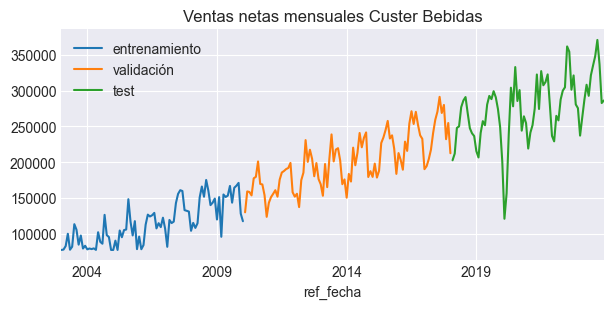

In [34]:
# Definir las fechas de corte
fin_train = '2010-02-01 23:59:59'
fin_val = '2018-02-01 23:59:59'
print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {datos.loc[fin_train:].index.min()} --- {datos.loc[:fin_val].index.max()}  "
    f"(n={len(datos.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {datos.loc[fin_val:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_val:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:fin_val].plot(ax=ax, label='validación')
datos.loc[fin_val:].plot(ax=ax, label='test')
ax.set_title('Ventas netas mensuales Custer Bebidas')
ax.legend();

In [35]:
# Grid search basado en backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(1, 0, 1), (1, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1), (2, 1, 0), (0, 1, 2)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12), (0, 1, 1, 12), (1, 1, 0, 12), (1, 0, 1, 12)],
    'trend': [None, 'n', 'c']
}

resultados_grid = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = datos.loc[:fin_val],
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_error',
                        initial_train_size    = len(datos_train),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )

resultados_grid.head(5)

Number of models compared: 180.


params grid:   0%|          | 0/180 [00:00<?, ?it/s]

params  mean_absolute_error  \
95   {'order': (1, 1, 0), 'seasonal_order': (0, 1, ...          9953.541924   
94   {'order': (1, 1, 0), 'seasonal_order': (0, 1, ...         10077.538735   
93   {'order': (1, 1, 0), 'seasonal_order': (0, 1, ...         10077.538735   
113  {'order': (1, 1, 1), 'seasonal_order': (0, 1, ...         12616.344736   
167  {'order': (0, 1, 2), 'seasonal_order': (0, 1, ...         12645.561142   

         order seasonal_order trend  
95   (1, 1, 0)  (0, 1, 0, 12)     c  
94   (1, 1, 0)  (0, 1, 0, 12)     n  
93   (1, 1, 0)  (0, 1, 0, 12)  None  
113  (1, 1, 1)  (0, 1, 0, 12)     c  
167  (0, 1, 2)  (0, 1, 0, 12)     c

In [36]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
modelo = auto_arima(
            y                 = datos.loc[:fin_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 4,
            max_q             = 4,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=4378.328, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4465.189, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4135.165, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4345.751, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4875.203, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4134.785, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4135.373, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=4136.853, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=4119.931, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=4110.246, Time=0.13 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=4104.882, Time=0.17 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=4105.229, Time=0.26 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=4107.454, Time=0.21 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=4135.056, Time=0.11 sec
 ARIMA(3,0,0)(2,0,0

In [37]:
# Predicciones de backtesting con el mejor modelo según el grid search
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(4, 0, 3), seasonal_order=(2, 0, 1, 12), maxiter=500),
             )

metrica_m1, predicciones_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = datos,
                                initial_train_size    = len(datos.loc[:fin_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

# Predicciones de backtesting con el mejor modelo según auto arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(4, 0, 4), seasonal_order=(2, 0, 1, 12), maxiter=500),
             )

metrica_m2, predicciones_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = datos,
                                initial_train_size    = len(datos.loc[:fin_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search :    mean_absolute_error
0         19928.752077
Metric (mean_absolute_error) del modelo auto arima   :    mean_absolute_error
0          19598.99067


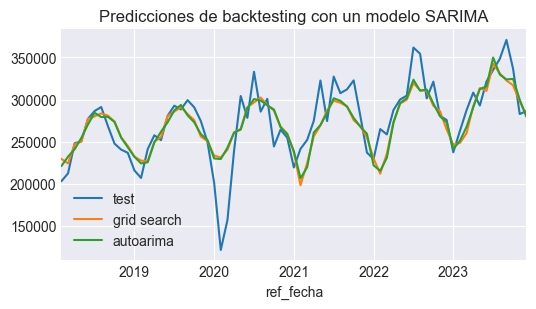

In [38]:
# Comparación de métricas
# ==============================================================================
print(f"Metrica (mean absolute error) del modelo grid search : {metrica_m1}")
print(f"Metric (mean_absolute_error) del modelo auto arima   : {metrica_m2}")

fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_val:].plot(ax=ax, label='test')
predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
predicciones_m2 = predicciones_m2.rename(columns={'pred': 'autoarima'})
predicciones_m1.plot(ax=ax)
predicciones_m2.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()

# PROYECCION CON MODELO HOLT WINTERS ADITIVO

In [39]:
# Definir el modelo Holt-Winters
modelo = ExponentialSmoothing(train['ref_doc_venta_neta'], seasonal='add', seasonal_periods=12)  

# Ajustar el modelo con los datos de entrenamiento
resultado = modelo.fit()

# Realizar predicciones en el conjunto de prueba
predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Crear un DataFrame separado para almacenar las predicciones
predicciones_df = pd.DataFrame({'Fecha': datos_test.index, 'Venta_Real': datos_test['ref_doc_venta_neta'], 'Ventas_Proyectadas': predicciones})

# Imprimir los resultados
print(predicciones_df)

                Fecha   Venta_Real  Ventas_Proyectadas
2017-10-31 2017-10-31  280044.1904       251981.973238
2017-11-30 2017-11-30  232255.3905       238475.586475
2017-12-31 2017-12-31  254820.6092       224903.638790
2018-01-31 2018-01-31  212610.2532       217075.837433
2018-02-28 2018-02-28  202786.2064       221866.145045
...               ...          ...                 ...
2023-08-31 2023-08-31  348337.6551       270551.514138
2023-09-30 2023-09-30  370862.4351       261562.375014
2023-10-31 2023-10-31  336602.7575       251981.973238
2023-11-30 2023-11-30  282714.3742       238475.586475
2023-12-31 2023-12-31  286303.9292       224903.638790

[75 rows x 3 columns]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


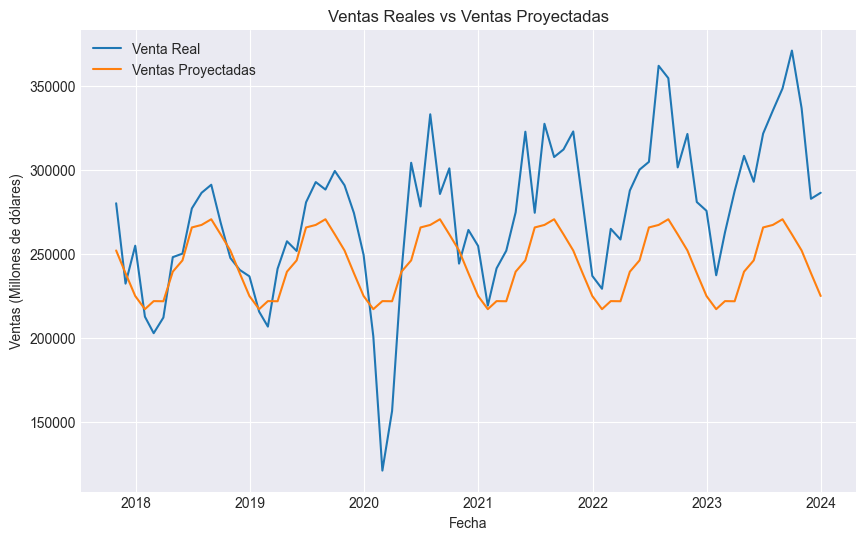

In [40]:
# Graficar las ventas reales y suavizadas
plt.figure(figsize=(10, 6))
plt.plot(predicciones_df['Fecha'], predicciones_df['Venta_Real'], label='Venta Real')
plt.plot(predicciones_df['Fecha'], predicciones_df['Ventas_Proyectadas'], label='Ventas Proyectadas')
plt.title('Ventas Reales vs Ventas Proyectadas')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Millones de dólares)')
plt.legend()
plt.show()

In [41]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 1973234728.3978572
MAE is : 35715.86911689593
RMSE is : 44421.106789429025
MAPE is : 12.995000100571769
R2 is : -0.002390012398242547



# PROYECCION CON MODELO HOLT WINTERS MULTIPLICATIVO

In [42]:
# Definir el modelo Holt-Winters
modelo = ExponentialSmoothing(train['ref_doc_venta_neta'], seasonal='mul', seasonal_periods=12)  

# Ajustar el modelo con los datos de entrenamiento
resultado = modelo.fit()

# Realizar predicciones en el conjunto de prueba
predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Crear un DataFrame separado para almacenar las predicciones
predicciones_df = pd.DataFrame({'Fecha': datos_test.index, 'Venta_Real': datos_test['ref_doc_venta_neta'], 'Ventas_Proyectadas': predicciones})

# Imprimir los resultados
print(predicciones_df)

                Fecha   Venta_Real  Ventas_Proyectadas
2017-10-31 2017-10-31  280044.1904       249198.437041
2017-11-30 2017-11-30  232255.3905       240529.677809
2017-12-31 2017-12-31  254820.6092       214892.991026
2018-01-31 2018-01-31  212610.2532       208921.875164
2018-02-28 2018-02-28  202786.2064       199522.006192
...               ...          ...                 ...
2023-08-31 2023-08-31  348337.6551       282596.197128
2023-09-30 2023-09-30  370862.4351       267232.919827
2023-10-31 2023-10-31  336602.7575       249198.437041
2023-11-30 2023-11-30  282714.3742       240529.677809
2023-12-31 2023-12-31  286303.9292       214892.991026

[75 rows x 3 columns]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


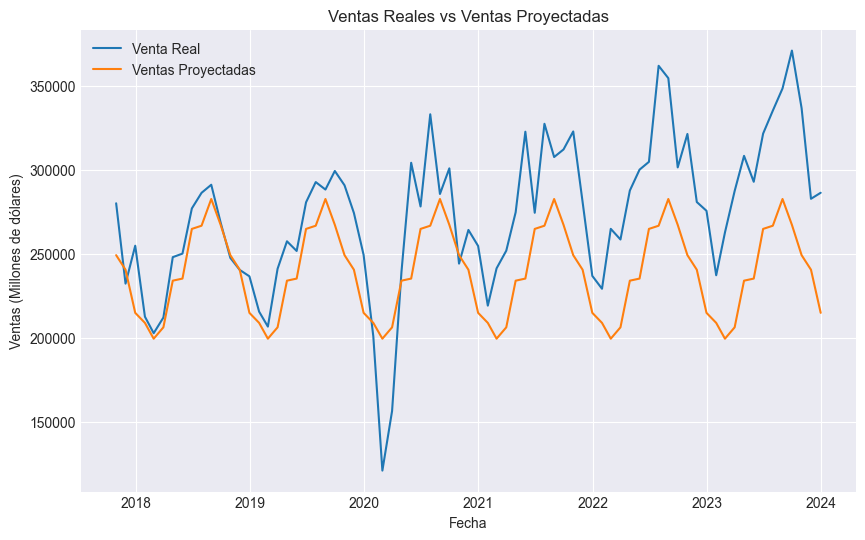

In [43]:
# Graficar las ventas reales y suavizadas
plt.figure(figsize=(10, 6))
plt.plot(predicciones_df['Fecha'], predicciones_df['Venta_Real'], label='Venta Real')
plt.plot(predicciones_df['Fecha'], predicciones_df['Ventas_Proyectadas'], label='Ventas Proyectadas')
plt.title('Ventas Reales vs Ventas Proyectadas')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Millones de dólares)')
plt.legend()
plt.show()

In [44]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 2138717212.634084
MAE is : 37732.203872922706
RMSE is : 46246.26701296099
MAPE is : 13.610890096162665
R2 is : -0.08645400490658761



# BUSQUEDA DE MEJORES HIPERPARAMETROS HOLT WINTERS

In [45]:
# Definir los rangos de valores para los hiperparámetros
param_grid = {
    'trend': ['add', 'mul'],  
    'seasonal': ['add', 'mul'],  
    'seasonal_periods': [12],  
    'smoothing_level': np.linspace(0.1, 1.0, 10),  # Rango de valores para alfa
    'smoothing_trend': np.linspace(0.1, 1.0, 10),  # Rango de valores para beta
    'smoothing_seasonal': np.linspace(0.1, 1.0, 10)  # Rango de valores para gamma
}

# Generar todas las combinaciones de hiperparámetros
param_combinations = list(ParameterGrid(param_grid))

# Función para calcular el MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Inicializar variables para almacenar los mejores hiperparámetros y el mejor modelo
best_score = float('inf')
best_params = None
best_model = None

# Iterar sobre todas las combinaciones de hiperparámetros
for params in param_combinations:
    # Definir y ajustar el modelo Holt-Winters con los hiperparámetros actuales
    modelo = ExponentialSmoothing(train['ref_doc_venta_neta'],
                                  trend=params['trend'],
                                  seasonal=params['seasonal'],
                                  seasonal_periods=params['seasonal_periods'],
                                  initialization_method="estimated")
    resultado = modelo.fit(smoothing_level=params['smoothing_level'],
                           smoothing_trend=params['smoothing_trend'],
                           smoothing_seasonal=params['smoothing_seasonal'])

    # Realizar predicciones en el conjunto de prueba
    predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

    # Calcular el MAPE
    mape = calculate_mape(datos_test['ref_doc_venta_neta'], predicciones)

    # Actualizar los mejores hiperparámetros y el mejor modelo si se encuentra un modelo con un mejor rendimiento
    if mape < best_score:
        best_score = mape
        best_params = params
        best_model = resultado

# Imprimir los mejores hiperparámetros y el mejor modelo
print("Mejores hiperparámetros:", best_params)
print("Error Porcentual Absoluto Medio (MAPE) en conjunto de prueba:", best_score)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sta

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], damp

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1380: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\ProgramData\Anaconda3\lib\site-pac

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\stat

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sta

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1380: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warni

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid val

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1380: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Chec

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1379: RuntimeWarning: overflow encountered in power
  b[nobs:] = dampen(b[nobs], phi_h)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1380: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1379: RuntimeWarning: overflow encountered in power
  b[nobs:] = dam

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: invalid value encountered in double_scalars
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning:

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

Mejores hiperparámetros: {'seasonal': 'add', 'seasonal_periods': 12, 'smoothing_level': 0.2, 'smoothing_seasonal': 0.5, 'smoothing_trend': 0.2, 'trend': 'add'}
Error Porcentual Absoluto Medio (MAPE) en conjunto de prueba: 6.425857016577151


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1352: RuntimeWarning: overflow encountered in power
  b[nobs:] = dampen(b[nobs], phi_h)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1353: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_

In [46]:
# Definir los hiperparámetros obtenidos
hiperparametros = {
    'seasonal': best_params['seasonal'],
    'seasonal_periods': best_params['seasonal_periods'],
    'smoothing_level': best_params['smoothing_level'],
    'smoothing_seasonal': best_params['smoothing_seasonal'],
    'smoothing_trend': best_params['smoothing_trend'],
    'trend': best_params['trend']
}


# Definir el modelo Holt-Winters sin pasar directamente los hiperparámetros al constructor
modelo = ExponentialSmoothing(train['ref_doc_venta_neta'], seasonal_periods=hiperparametros['seasonal_periods'], trend=hiperparametros['trend'], seasonal=hiperparametros['seasonal'])

# Ajustar el modelo con los datos de entrenamiento y los hiperparámetros obtenidos
resultado = modelo.fit(smoothing_level=hiperparametros['smoothing_level'], smoothing_trend=hiperparametros['smoothing_trend'], smoothing_seasonal=hiperparametros['smoothing_seasonal'])

# Realizar predicciones en el conjunto de prueba
predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Crear un DataFrame separado para almacenar las predicciones
predicciones_df = pd.DataFrame({'Fecha': datos_test.index,
                                'Venta_Real': datos_test['ref_doc_venta_neta'],
                                'Ventas_Proyectadas': predicciones})

# Imprimir los resultados
print(predicciones_df)

                Fecha   Venta_Real  Ventas_Proyectadas
2017-10-31 2017-10-31  280044.1904       259850.810954
2017-11-30 2017-11-30  232255.3905       237286.857527
2017-12-31 2017-12-31  254820.6092       223529.610623
2018-01-31 2018-01-31  212610.2532       204458.223776
2018-02-28 2018-02-28  202786.2064       210421.908370
...               ...          ...                 ...
2023-08-31 2023-08-31  348337.6551       343678.081578
2023-09-30 2023-09-30  370862.4351       332680.420731
2023-10-31 2023-10-31  336602.7575       321300.137051
2023-11-30 2023-11-30  282714.3742       298736.183624
2023-12-31 2023-12-31  286303.9292       284978.936720

[75 rows x 3 columns]


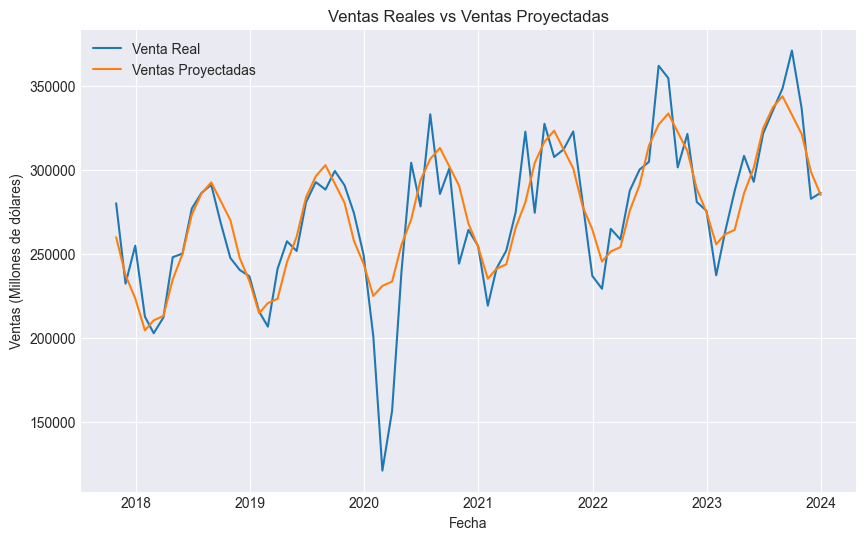

In [47]:
# Graficar las ventas reales y suavizadas
plt.figure(figsize=(10, 6))
plt.plot(predicciones_df['Fecha'], predicciones_df['Venta_Real'], label='Venta Real')
plt.plot(predicciones_df['Fecha'], predicciones_df['Ventas_Proyectadas'], label='Ventas Proyectadas')
plt.title('Ventas Reales vs Ventas Proyectadas')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Millones de dólares)')
plt.legend()
plt.show()

In [48]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 518251484.9463156
MAE is : 15092.57534913579
RMSE is : 22765.137490169385
MAPE is : 6.425857016577151
R2 is : 0.7367317202842165



# RED NEURONAL LSTM

## PRUEBA LSTM 1

In [49]:
scaler = MinMaxScaler()

In [50]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [51]:
scaled_test_data.shape

(75, 1)

In [52]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [53]:
generator

In [54]:


lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(200, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200)            │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,801 (632.04 KB)

 Trainable params: 161,801 (632.04 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
lstm_model.fit(generator, epochs=400)


Epoch 1/400
 33/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0555

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1d602dcb9a0>


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0333
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0165
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0052
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045
Epoch 94/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0036
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0037
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0041
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029
Epoch 172/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025
Epoch 173/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0018
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0026
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 250/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027
Epoch 251/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0015
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0012
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0017
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010   
Epoch 328/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011
Epoch 329/400
165/165 ━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6705e-04
Epoch 393/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7596e-04
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8726e-04
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1245e-04
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3165e-04
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4646e-04
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7477e-04
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.6426e-04


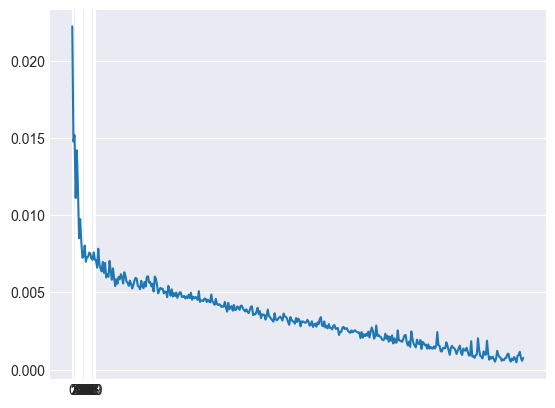

In [56]:
losses_lstm = lstm_model.history.history['loss']
#plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [57]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

In [58]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [59]:
lstm_predictions

array([[271891.34878008],
       [251619.69592857],
       [211904.04757705],
       [203533.27030004],
       [214179.00916009],
       [205621.50679684],
       [224468.32615588],
       [246393.45832389],
       [259594.64151425],
       [289229.9265262 ],
       [284182.04005679],
       [295715.12456724],
       [271518.15352241],
       [258441.96780104],
       [223888.5606953 ],
       [228261.70045208],
       [207152.46131786],
       [229018.79738875],
       [218460.62176027],
       [267745.86067963],
       [255289.43654993],
       [295802.8152562 ],
       [296949.93182691],
       [292361.21062927],
       [279721.00567921],
       [273686.75190786],
       [242619.750704  ],
       [222140.11287248],
       [233187.69941299],
       [212749.85486186],
       [252173.49831743],
       [237002.89441552],
       [302459.17583533],
       [276692.57969532],
       [308111.32507697],
       [295388.73166565],
       [299311.02911867],
       [266938.74946048],
       [2522

In [60]:
datos_test['LSTM_Predictions'] = lstm_predictions

In [61]:
datos_test

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31         280044.1904     271891.348780
2017-11-30         232255.3905     251619.695929
2017-12-31         254820.6092     211904.047577
2018-01-31         212610.2532     203533.270300
2018-02-28         202786.2064     214179.009160
...                        ...               ...
2023-08-31         348337.6551     301094.693420
2023-09-30         370862.4351     350220.291950
2023-10-31         336602.7575     300844.774957
2023-11-30         282714.3742     315261.226188
2023-12-31         286303.9292     275194.827826

[75 rows x 2 columns]

In [62]:
ai=datos_test[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=datos_test.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [63]:
evaluacion_metrica(datos_test["ref_doc_venta_neta"],datos_test["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 1016230982.044574
MAE is : 23139.730002527103
RMSE is : 31878.37797072765
MAPE is : 9.129155614884098
R2 is : 0.48376147448092677



In [64]:
datos_test = datos_test.drop(columns=['LSTM_Predictions'])

## PRUEBA LSTM 2

In [65]:
scaler = MinMaxScaler()

In [66]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [67]:
scaled_test_data.shape

(75, 1)

In [68]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [69]:
generator

Epoch 1/400
 20/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3122

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

sys:1: ResourceWarning:

unclosed socket <zmq.Socket(zmq.PUSH) at 0x1d668248940>



165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.6926
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0508
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0385
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0242
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0209
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0248
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0194
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0200
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0249
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0171
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0201
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0171
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0186
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0175
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0189
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0183
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0122
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0151
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0176
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0221
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0168
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0161
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0150
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0150
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0162
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0143
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0141
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0194
Epoch 94/400
165/165 ━━━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0137
Epoch 159/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0143
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0160
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0155
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0120
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0140
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0149
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0130
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0142
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0126 
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0127
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0159
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0153
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0153
Epoch 172/400
165/165 ━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0140
Epoch 237/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0112
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0120
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0118
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0133
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0117
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0120
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0124
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0126
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0131
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0120
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0120
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132
Epoch 250/400
165/165 ━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104
Epoch 315/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0115
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0119
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0122
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0135
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0112
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0119
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0134
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0129
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0128
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0126
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0114
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103
Epoch 328/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0102
Epoch 393/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0135
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0118
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0119
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0144


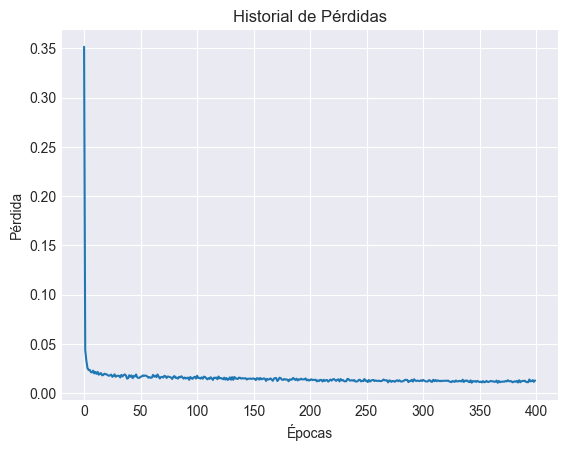

In [70]:
regularization = regularizers.l2(0.01)  

# Define el modelo LSTM
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(100, activation='tanh', return_sequences=True, kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(LSTM(50, activation='relu', kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(Dense(1))

# Define el optimizador que deseas probar (por ejemplo, RMSprop)
optimizer = RMSprop(learning_rate=0.001)

# Compila el modelo con el nuevo optimizador
lstm_model.compile(optimizer=optimizer, loss='mse')

# Define el tamaño de lote y el número de épocas que deseas probar
batch_size = 1
epochs = 400

# Entrena el modelo con los nuevos hiperparámetros
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


In [71]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

In [72]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [73]:
lstm_predictions

array([[237345.72932128],
       [228800.85798606],
       [219171.68108523],
       [197938.0180403 ],
       [204499.26990998],
       [214707.15437498],
       [226272.01401444],
       [238538.9472324 ],
       [246320.99879384],
       [250823.09994465],
       [253470.59400689],
       [243251.04719008],
       [229587.69073339],
       [222927.41721218],
       [214613.95752648],
       [205548.58842017],
       [212584.96322769],
       [220788.14677372],
       [228606.58742194],
       [234835.35392646],
       [238266.30311502],
       [239672.61704775],
       [238721.9378169 ],
       [232549.60944766],
       [224972.16524521],
       [219833.28694026],
       [214500.30376581],
       [211995.16686999],
       [217869.44886268],
       [223658.14321346],
       [228416.44647747],
       [231570.45623438],
       [233004.64509978],
       [233046.10699094],
       [231331.11673477],
       [227110.2885671 ],
       [222345.4339929 ],
       [218797.49165987],
       [2161

In [74]:
test_data1 = datos_test.copy()

In [75]:
test_data1['LSTM_Predictions'] = lstm_predictions

In [76]:
test_data1

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31         280044.1904     237345.729321
2017-11-30         232255.3905     228800.857986
2017-12-31         254820.6092     219171.681085
2018-01-31         212610.2532     197938.018040
2018-02-28         202786.2064     204499.269910
...                        ...               ...
2023-08-31         348337.6551     223172.772701
2023-09-30         370862.4351     221773.851297
2023-10-31         336602.7575     220699.410934
2023-11-30         282714.3742     220318.746673
2023-12-31         286303.9292     220750.279181

[75 rows x 2 columns]

In [77]:
ai=test_data1[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data1.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [78]:
evaluacion_metrica(test_data1["ref_doc_venta_neta"],test_data1["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 4031170032.7073073
MAE is : 52620.197654857744
RMSE is : 63491.49575106344
MAPE is : 18.57335589855605
R2 is : -1.0478073494813165



## PRUEBA LSTM 3

In [79]:
scaler = MinMaxScaler()

In [80]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [81]:
scaled_test_data.shape

(75, 1)

In [82]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [83]:
generator

In [84]:
# Define la regularización L1 o L2 que deseas probar
regularization = regularizers.l2(0.01) 

# Define el modelo LSTM usando Input en lugar de input_shape
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(100, activation='tanh', return_sequences=True, kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(LSTM(50, activation='relu', kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(Dense(1))

# Define el optimizador que deseas probar (por ejemplo, RMSprop)
optimizer = RMSprop(learning_rate=0.001)

# Compila el modelo con el nuevo optimizador
lstm_model.compile(optimizer=optimizer, loss='mse')

# Define el tamaño de lote y el número de épocas que deseas probar
batch_size = 1
epochs = 400

# Entrena el modelo con los nuevos hiperparámetros
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


Epoch 1/400
 17/165 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3108

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

sys:1: ResourceWarning:

unclosed socket <zmq.Socket(zmq.PUSH) at 0x1d60907dac0>



165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.6761
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0521
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0334
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0301
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0251
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0238
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0227
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0228
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0215
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0174
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0177
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0164
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0191
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0176
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0156
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0167
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0157
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0162
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0150
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0139
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0162
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0144
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0169
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0220
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0175
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0152
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0137
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0189
Epoch 94/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0143
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0153
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0163
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0160
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0140
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0123
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0123
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0140
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0134
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0135
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0136
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0168
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0158
Epoch 172/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0183
Epoch 173/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0136
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0146
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0137
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0122
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0126
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0149
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0128
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0123
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0124
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0124
Epoch 250/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0131
Epoch 251/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0112
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0126
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0106
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0130
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0119
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0138
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0151
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0126
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0124
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0140
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0113
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0157
Epoch 328/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0116
Epoch 329/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0134
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0124
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0127
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0151
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0124
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0134
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0130


In [85]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

In [86]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [87]:
lstm_predictions

array([[259905.62481657],
       [249077.36696438],
       [237288.57742458],
       [211612.2975959 ],
       [220074.35986047],
       [232745.63892385],
       [246898.66120737],
       [261987.42471484],
       [271768.45435814],
       [277717.8979777 ],
       [281869.58050763],
       [271791.10353754],
       [265758.8763388 ],
       [257699.92358293],
       [247661.95257352],
       [236510.06764526],
       [245468.60196162],
       [255566.92404839],
       [264871.91306059],
       [272529.7573889 ],
       [277000.47852863],
       [279228.62500984],
       [279161.78635099],
       [274251.87251355],
       [270284.12375286],
       [265096.79889141],
       [259482.8613773 ],
       [256594.14144598],
       [262907.5906449 ],
       [268837.53328276],
       [273689.68342799],
       [277171.24594879],
       [279005.80398885],
       [279574.26397834],
       [278749.18126625],
       [276212.93201988],
       [273809.28944909],
       [270992.02213439],
       [2686

In [88]:
test_data2 = datos_test.copy()

In [89]:
test_data2['LSTM_Predictions'] = lstm_predictions

In [90]:
test_data2

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31         280044.1904     259905.624817
2017-11-30         232255.3905     249077.366964
2017-12-31         254820.6092     237288.577425
2018-01-31         212610.2532     211612.297596
2018-02-28         202786.2064     220074.359860
...                        ...               ...
2023-08-31         348337.6551     279832.569139
2023-09-30         370862.4351     279491.875517
2023-10-31         336602.7575     279200.138282
2023-11-30         282714.3742     279032.276890
2023-12-31         286303.9292     279101.040156

[75 rows x 2 columns]

In [91]:
ai=test_data2[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data2.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [92]:
evaluacion_metrica(test_data2["ref_doc_venta_neta"],test_data2["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 1407704906.7094817
MAE is : 26989.674311120187
RMSE is : 37519.39374123044
MAPE is : 10.891170238732126
R2 is : 0.2848953454030865



## PRUEBA LSTM 4

In [93]:
scaler = MinMaxScaler()

In [94]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [95]:
scaled_test_data.shape

(75, 1)

In [96]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [97]:
generator

In [98]:
batch_size=1
epochs = 600

In [99]:
# Define la función para crear el modelo LSTM
def create_lstm_model(units=100, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(n_input, n_features)))  
    model.add(LSTM(units=units, activation='relu'))  
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Define una clase de envoltura para el modelo de Keras
class KerasWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, units=100, optimizer='adam'):
        self.units = units
        self.optimizer = optimizer
        self.model = None

    def fit(self, X, y):
        self.model = create_lstm_model(units=self.units, optimizer=self.optimizer)
        self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Define los parámetros a buscar
param_grid = {
    'units': [50, 100, 200],
    'optimizer': ['adam', 'rmsprop']
}

# Define el esquema de validación cruzada KFold
kf = KFold(n_splits=5, shuffle=True)

# Envuelve el modelo en la clase KerasWrapper
keras_model_wrapper = KerasWrapper()

# Realiza la búsqueda de hiperparámetros utilizando GridSearchCV con KFold
grid_search = GridSearchCV(estimator=keras_model_wrapper, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(scaled_train_data, scaled_train_data)

# Muestra los resultados de la búsqueda de hiperparámetros
print("Mejor MSE: {:.4f}".format(-grid_result.best_score_))
print("Mejores Parámetros: ", grid_result.best_params_)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/stepWARNING:tensorflow:5 out of the last 79 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001D609979040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


tensorflow WARNING 5 out of the last 79 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001D609979040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


tensorflow WARNING 6 out of the last 80 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001D60BD284C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/ste

In [100]:
# Define los mejores parámetros obtenidos de la búsqueda de hiperparámetros
best_optimizer = 'adam'
best_units = 200

# Construye el modelo LSTM con los mejores parámetros
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(units=best_units, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=best_optimizer, loss='mse')

# Entrena el modelo con los datos de entrenamiento
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


Epoch 1/600
 56/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0731

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

sys:1: ResourceWarning:

unclosed socket <zmq.Socket(zmq.PUSH) at 0x1d6254b2d00>



165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0429
Epoch 2/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173
Epoch 3/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167
Epoch 4/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146
Epoch 5/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104
Epoch 6/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117
Epoch 7/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066
Epoch 8/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087
Epoch 9/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067
Epoch 10/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087
Epoch 11/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069
Epoch 12/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096
Epoch 13/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061
Epoch 14/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056
Epoch 15/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039
Epoch 81/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051
Epoch 82/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0046
Epoch 83/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053
Epoch 84/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0040
Epoch 85/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042
Epoch 86/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042
Epoch 87/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0037
Epoch 88/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039
Epoch 89/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050
Epoch 90/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041
Epoch 91/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048
Epoch 92/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041
Epoch 93/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0046
Epoch 94/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026
Epoch 160/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0027
Epoch 161/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031
Epoch 162/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026
Epoch 163/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029
Epoch 164/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023
Epoch 165/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021
Epoch 166/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021
Epoch 167/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023
Epoch 168/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031
Epoch 169/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024
Epoch 170/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024
Epoch 171/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035
Epoch 172/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020
Epoch 173/600
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015
Epoch 238/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 239/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016
Epoch 240/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020
Epoch 241/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012
Epoch 242/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017
Epoch 243/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 244/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014
Epoch 245/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018
Epoch 246/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021
Epoch 247/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6503e-04
Epoch 248/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014
Epoch 249/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017
Epoch 250/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024
Epoch 251/600
165/165 ━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8139e-04
Epoch 315/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012  
Epoch 316/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013
Epoch 317/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8565e-04
Epoch 318/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 319/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6146e-04
Epoch 320/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8350e-04
Epoch 321/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4007e-04
Epoch 322/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3714e-04
Epoch 323/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7471e-04
Epoch 324/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5665e-04
Epoch 325/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5068e-04
Epoch 326/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0678e-04
Epoch 327/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss:

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0274e-04
Epoch 391/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0893e-04
Epoch 392/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8998e-04
Epoch 393/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7780e-04
Epoch 394/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.5618e-04
Epoch 395/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1422e-04
Epoch 396/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 397/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1676e-04
Epoch 398/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8779e-04
Epoch 399/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0865e-04
Epoch 400/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5963e-04
Epoch 401/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7625e-04
Epoch 402/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.8586e-04
Epoch 403/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.1955e-04
Epoch 467/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7478e-04
Epoch 468/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7697e-04
Epoch 469/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5527e-05
Epoch 470/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3390e-05
Epoch 471/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9029e-05
Epoch 472/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.6649e-05
Epoch 473/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.5416e-05
Epoch 474/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4098e-05
Epoch 475/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1946e-05
Epoch 476/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5178e-04
Epoch 477/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8799e-04
Epoch 478/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3805e-04
Epoch 479/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2281e-05
Epoch 543/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9078e-05
Epoch 544/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2252e-05
Epoch 545/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7115e-05
Epoch 546/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4375e-04
Epoch 547/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4004e-04
Epoch 548/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.8723e-04
Epoch 549/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3239e-04
Epoch 550/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5612e-04
Epoch 551/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7728e-04
Epoch 552/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2202e-04
Epoch 553/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014
Epoch 554/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9611e-04
Epoch 555/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

In [101]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

In [102]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [103]:
lstm_predictions

array([[ 267711.0903018 ],
       [ 255366.63749514],
       [ 236467.57334918],
       [ 218194.5671903 ],
       [ 207940.28823288],
       [ 215886.95102222],
       [ 236515.91793977],
       [ 249326.64814094],
       [ 271447.72056497],
       [ 296184.21877022],
       [ 291407.37045499],
       [ 289170.00880399],
       [ 274283.83882866],
       [ 265270.31939134],
       [ 234443.95775253],
       [ 219173.23606547],
       [ 221098.90065273],
       [ 237352.34436017],
       [ 250574.83842727],
       [ 269543.41783741],
       [ 296004.60580673],
       [ 300738.01664115],
       [ 298799.49160257],
       [ 284087.27548231],
       [ 273219.49309139],
       [ 264619.36897468],
       [ 229251.38164633],
       [ 239647.13831414],
       [ 246518.11165791],
       [ 257759.84130514],
       [ 278877.77303382],
       [ 292436.76737407],
       [ 303344.57138756],
       [ 301642.76022621],
       [ 291496.66710715],
       [ 281961.43905347],
       [ 271325.82031072],
 

In [104]:
test_data3 = datos_test.copy()

In [105]:
test_data3['LSTM_Predictions'] = lstm_predictions

In [106]:
test_data3

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31         280044.1904      2.677111e+05
2017-11-30         232255.3905      2.553666e+05
2017-12-31         254820.6092      2.364676e+05
2018-01-31         212610.2532      2.181946e+05
2018-02-28         202786.2064      2.079403e+05
...                        ...               ...
2023-08-31         348337.6551      1.097670e+06
2023-09-30         370862.4351      1.271534e+06
2023-10-31         336602.7575      1.404002e+06
2023-11-30         282714.3742      1.258201e+06
2023-12-31         286303.9292      1.114592e+06

[75 rows x 2 columns]

In [107]:
ai=test_data3[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data3.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [108]:
evaluacion_metrica(test_data3["ref_doc_venta_neta"],test_data3["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 70850656407.55562
MAE is : 118273.08053260793
RMSE is : 266177.8661112821
MAPE is : 40.22384378158092
R2 is : -34.991658434096735



## PRUEBA LSTM 5

In [109]:
# Define la regularización L1 o L2 que deseas probar
regularization = regularizers.l2(0.01)  # Regularización L2 con un valor de 0.01

# Define el modelo LSTM usando Input en lugar de input_shape
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(200, activation='tanh', return_sequences=True, kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(LSTM(100, activation='relu', kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(Dense(1))

# Define el optimizador que deseas probar (por ejemplo, RMSprop)
optimizer = RMSprop(learning_rate=0.001)

# Compila el modelo con el nuevo optimizador
lstm_model.compile(optimizer=optimizer, loss='mse')

# Define el tamaño de lote y el número de épocas que deseas probar
batch_size = 1
epochs = 400

# Entrena el modelo con los nuevos hiperparámetros
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


Epoch 1/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0773
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0440
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0295
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0295
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0235
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0222
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0196
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0171
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0224
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0180
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0195
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0229
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0180
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0167
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0156
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0147
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0153
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0127
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0160
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0159
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0149
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0149
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0137
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0168
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0189
Epoch 94/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0143
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0179
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0167
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0125
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0121
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0145
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0147
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0144
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0125
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0152
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0138
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0156
Epoch 172/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134
Epoch 173/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0166
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0139
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0117
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0138
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0136
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0138
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0125
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0101
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0139
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0118
Epoch 250/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0136
Epoch 251/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0115
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0138
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0119
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0114
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0102
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0120
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0125
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0115
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0127
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0116
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0114
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0122
Epoch 328/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0133
Epoch 329/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0132
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0100
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0137
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0121
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0099
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0121


In [110]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━

In [111]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [112]:
lstm_predictions

array([[250521.91811614],
       [239432.74222708],
       [227453.46760784],
       [204639.95738451],
       [213511.1196554 ],
       [226435.09575358],
       [240617.52245853],
       [255194.71021267],
       [264601.98378576],
       [269887.05572478],
       [272526.82586878],
       [260942.75839963],
       [250310.23687163],
       [241402.46883638],
       [231407.99903649],
       [222924.3072517 ],
       [233126.40515089],
       [244039.40942618],
       [253626.95874122],
       [261157.98295977],
       [265236.36474084],
       [266610.73784995],
       [265046.8101004 ],
       [258251.44448439],
       [251575.12407693],
       [245466.6008805 ],
       [240239.80246327],
       [239570.58740166],
       [247462.1248669 ],
       [254416.32789075],
       [259700.07427284],
       [263139.56310698],
       [264561.65626543],
       [264284.97174857],
       [262152.91539877],
       [258014.78159011],
       [253989.88093271],
       [250690.85014979],
       [2490

In [113]:
test_data4 = datos_test.copy()

In [114]:
test_data4['LSTM_Predictions'] = lstm_predictions

In [115]:
test_data4

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31         280044.1904     250521.918116
2017-11-30         232255.3905     239432.742227
2017-12-31         254820.6092     227453.467608
2018-01-31         212610.2532     204639.957385
2018-02-28         202786.2064     213511.119655
...                        ...               ...
2023-08-31         348337.6551     262031.295551
2023-09-30         370862.4351     261388.323967
2023-10-31         336602.7575     261034.757149
2023-11-30         282714.3742     261102.691941
2023-12-31         286303.9292     261602.809274

[75 rows x 2 columns]

In [116]:
ai=test_data4[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data4.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [117]:
evaluacion_metrica(test_data4["ref_doc_venta_neta"],test_data4["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 1782788733.9442704
MAE is : 31469.55678141351
RMSE is : 42223.08295167787
MAPE is : 11.828586662775562
R2 is : 0.09435527593171

